# Testing MSE in Consistency Denoising

/home/anton/source/torch-env/lib/python3.12/site-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)


Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

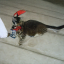

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np

from torchvision import transforms 

from diffusers import ConsistencyModelPipeline

device = "cuda"
model_id_or_path = "openai/diffusers-cd_imagenet64_l2"
pipe = ConsistencyModelPipeline.from_pretrained(model_id_or_path, torch_dtype=torch.float16)
pipe.to(device)

CLASS = [281]

preprocess = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5]),
        ]
    )

#pipe.unet = torch.compile(pipe.unet, mode="reduce-overhead", fullgraph=True)

# Multistep sampling
# Timesteps can be explicitly specified; the particular timesteps below are from the original GitHub repo:
# https://github.com/openai/consistency_models/blob/main/scripts/launch.sh#L83
image = pipe(num_inference_steps=40, class_labels=CLASS).images[0]
image

In [2]:
pipe.scheduler.sigmas

tensor([8.0000e+01, 6.9451e+01, 6.0117e+01, 5.1880e+01, 4.4630e+01, 3.8266e+01,
        3.2697e+01, 2.7837e+01, 2.3610e+01, 1.9946e+01, 1.6780e+01, 1.4055e+01,
        1.1719e+01, 9.7232e+00, 8.0265e+00, 6.5901e+00, 5.3800e+00, 4.3656e+00,
        3.5197e+00, 2.8184e+00, 2.2404e+00, 1.7672e+00, 1.3824e+00, 1.0717e+00,
        8.2294e-01, 6.2540e-01, 4.6998e-01, 3.4892e-01, 2.5563e-01, 1.8459e-01,
        1.3120e-01, 9.1628e-02, 6.2762e-02, 4.2071e-02, 2.7525e-02, 1.7522e-02,
        1.0812e-02, 6.4371e-03, 3.6766e-03, 2.0000e-03, 2.0000e-03])

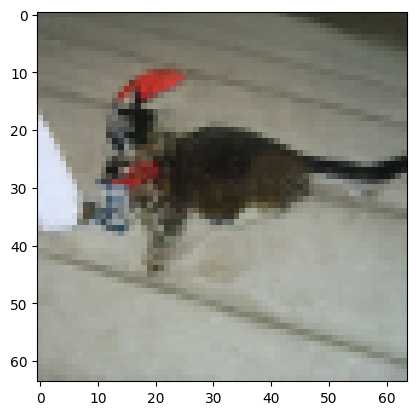

In [3]:
plt.imshow(
    np.moveaxis(np.array(transforms.ToTensor()(image)), 0, -1)
)

## Denoiser

In [4]:
def denoise(sample, sigma):
    #sample = torch.Tensor(sample, device=device, dtype=torch.float16)
    
    t = pipe.scheduler.sigma_to_t(sigma)

    #pipe.scheduler.set_timesteps([t, 0])
    
    c_skip, c_out = pipe.scheduler.get_scalings_for_boundary_condition(sigma)

    # this is definitely not working correctly!
    # check initialization of step index
    # scaled_sample = pipe.scheduler.scale_model_input(sample, t)
    scaled_sample = sample / ((sigma**2 + 1) ** 0.5)
    
    model_output = pipe.unet(
        scaled_sample, 
        t, 
        class_labels=torch.tensor(CLASS, device=device),
        return_dict=False
    )[0]

    
    return  c_out * model_output + c_skip * sample

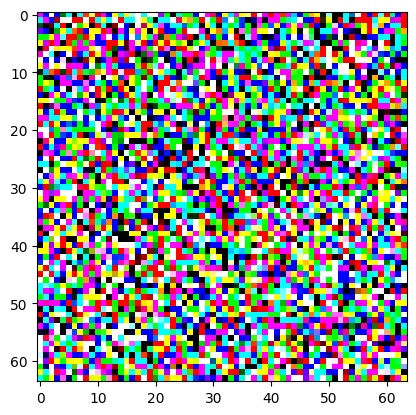

In [5]:
sigma = 7

img = preprocess(image)[None, :].to(device).type(torch.float16)
z = sigma * torch.randn(img.shape).to(device).type(torch.float16)

plt.imshow(
    pipe.postprocess_image((img + z).type(torch.float32), "np")[0]
)

/tmp/ipykernel_4001/3109570201.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img_dn = torch.tensor(denoise(img + z, sigma).detach(), dtype=torch.float32)


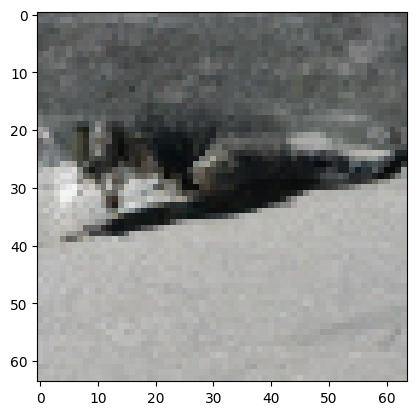

In [6]:
img_dn = torch.tensor(denoise(img + z, sigma).detach(), dtype=torch.float32)

plt.imshow(
    pipe.postprocess_image(img_dn.cpu(), "np")[0]
)

/tmp/ipykernel_4001/2744246053.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pipe.postprocess_image(torch.tensor(img_dn, dtype=torch.float32).detach().cpu(), "np")[0]


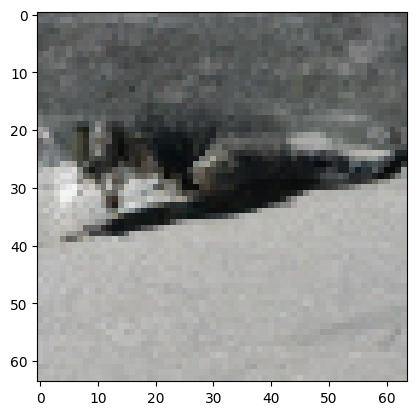

In [7]:
def denoise_v(img_v):
    sample = torch.reshape(img_v, (1,3,64,64))
    sample_dn = denoise(sample, sigma)
    return torch.reshape(sample_dn, (12288,))

img_noisy = img + z

img_dn_v = denoise_v(torch.reshape(img_noisy, (12288,)))
img_dn = torch.reshape(img_dn_v, (1,3,64,64))
plt.imshow(
    pipe.postprocess_image(torch.tensor(img_dn, dtype=torch.float32).detach().cpu(), "np")[0]
)

In [8]:
timesteps = list(reversed(range(40)))
pipe.scheduler.set_timesteps(timesteps=timesteps, device=device)
pipe.scheduler.sigmas

tensor([8.0000e+01, 6.9451e+01, 6.0117e+01, 5.1880e+01, 4.4630e+01, 3.8266e+01,
        3.2697e+01, 2.7837e+01, 2.3610e+01, 1.9946e+01, 1.6780e+01, 1.4055e+01,
        1.1719e+01, 9.7232e+00, 8.0265e+00, 6.5901e+00, 5.3800e+00, 4.3656e+00,
        3.5197e+00, 2.8184e+00, 2.2404e+00, 1.7672e+00, 1.3824e+00, 1.0717e+00,
        8.2294e-01, 6.2540e-01, 4.6998e-01, 3.4892e-01, 2.5563e-01, 1.8459e-01,
        1.3120e-01, 9.1628e-02, 6.2762e-02, 4.2071e-02, 2.7525e-02, 1.7522e-02,
        1.0812e-02, 6.4371e-03, 3.6766e-03, 2.0000e-03, 2.0000e-03])

## Loop over sigma

In [9]:
timesteps = list(reversed(range(40)))
pipe.scheduler.set_timesteps(timesteps=timesteps, device=device)
sigmas = pipe.scheduler.sigmas

from torch.autograd.functional import jacobian, vjp

N_TRACE = 50
N_NOISE = 2

mse = []
bias = []
traces = []

samples_noise = []
samples_denoised = []

img = preprocess(image)[None, :].to(device).requires_grad_(True).type(torch.float16)

for i, sigma in enumerate(reversed(sigmas)[1:]):

    print(f"{i+1}: sigma = %.3f " % sigma)
    
    mse_sigma = []    
    bias_sigma = []
    traces_sigma = []

    N_NOISE = 5 if i>22 else 1

    N_NOISE = 15 if i>30 else 1
    
    for j in range(N_NOISE):

        print(f"{i+1}: {j+1}/{N_NOISE} noisy samples")
    
        
        # add noise to original image
        img_noisy = img + sigma * torch.randn(img.shape).to(device).type(torch.float16)
        #samples_noise.append(img_noisy)
    
        # denoise
        img_dn = torch.tensor(
            denoise(img_noisy, sigma).detach(), 
            dtype=torch.float32
        )
        #samples_denoised.append(img_dn)
    
        # compute MSE
        diff_dn_s = torch.tensor(img_dn - img, dtype=torch.float32).clone().detach().cpu()
        mse_sigma.append(torch.sum(diff_dn_s * diff_dn_s))
    
        #mse.append(
        #    np.linalg.norm(pipe.postprocess_image(img_dn.detach().cpu(), "np") - pipe.postprocess_image(img.detach().cpu(), "np"))
        #)
    
        # compute bias
        diff_dn_n = torch.tensor(img_dn - img_noisy, dtype=torch.float32).clone().detach().cpu()
        bias_sigma.append(torch.sum(diff_dn_n * diff_dn_n))
    
    
        # helper for vector inputs
        def denoise_v(img_v):
            sample = torch.reshape(img_v, (1,3,64,64))
            sample_dn = denoise(sample, sigma)
            return torch.reshape(sample_dn, (12288,))
    
        # compute trace
        trace = torch.tensor(0, device=device, dtype=torch.float)
        img_noisy_v = torch.reshape(img_noisy, (12288,)).requires_grad_(True).type(torch.float16)
    
        # hutchinson estimator
        for _ in range(N_TRACE):
            eps = torch.randn(
                (12288,), 
                device=device
            ).type(torch.float16)
            prod = vjp(
                denoise_v, 
                inputs=img_noisy_v, 
                v=eps
            )[1]
            trace += torch.sum(eps * prod)
            
        trace /= N_TRACE
        
        traces_sigma.append(trace)
        #print(f"{j+1}/{N_NOISE}: ended")

    mse.append(torch.mean(torch.tensor(mse_sigma)).detach().cpu())
    bias.append(torch.mean(torch.tensor(bias_sigma)).detach().cpu())
    traces.append(torch.mean(torch.tensor(traces_sigma)).detach().cpu())
    
    #print(f"{i+1}: sigma = %.3f. finished" % sigma)

/tmp/ipykernel_4001/1738191729.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img_dn = torch.tensor(
/tmp/ipykernel_4001/1738191729.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  diff_dn_s = torch.tensor(img_dn - img, dtype=torch.float32).clone().detach().cpu()
/tmp/ipykernel_4001/1738191729.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  diff_dn_n = torch.tensor(img_dn - img_noisy, dtype=torch.float32).clone().detach().cpu()


1: sigma = 0.002 
1: 1/1 noisy samples
2: sigma = 0.004 
2: 1/1 noisy samples
3: sigma = 0.006 
3: 1/1 noisy samples
4: sigma = 0.011 
4: 1/1 noisy samples
5: sigma = 0.018 
5: 1/1 noisy samples
6: sigma = 0.028 
6: 1/1 noisy samples
7: sigma = 0.042 
7: 1/1 noisy samples
8: sigma = 0.063 
8: 1/1 noisy samples
9: sigma = 0.092 
9: 1/1 noisy samples
10: sigma = 0.131 
10: 1/1 noisy samples
11: sigma = 0.185 
11: 1/1 noisy samples
12: sigma = 0.256 
12: 1/1 noisy samples
13: sigma = 0.349 
13: 1/1 noisy samples
14: sigma = 0.470 
14: 1/1 noisy samples
15: sigma = 0.625 
15: 1/1 noisy samples
16: sigma = 0.823 
16: 1/1 noisy samples
17: sigma = 1.072 
17: 1/1 noisy samples
18: sigma = 1.382 
18: 1/1 noisy samples
19: sigma = 1.767 
19: 1/1 noisy samples
20: sigma = 2.240 
20: 1/1 noisy samples
21: sigma = 2.818 
21: 1/1 noisy samples
22: sigma = 3.520 
22: 1/1 noisy samples
23: sigma = 4.366 
23: 1/1 noisy samples
24: sigma = 5.380 
24: 1/1 noisy samples
25: sigma = 6.590 
25: 1/1 noisy s

In [10]:
TRACES_SAVE = traces
BIAS_SAVE = bias
MSE_SAVE = mse

## Plotting

The SURE is shown by Mallat to be
$$
\mathbb{E}_y \left( ||f(y) - y||^2 + 2 \sigma^2 \text{tr} \nabla f (y) - \sigma^2 d \right)
$$
where $y \sim N(x, \sigma^2)$ and $f(y) = \hat x$, i.e. $f$ is a denoising function.

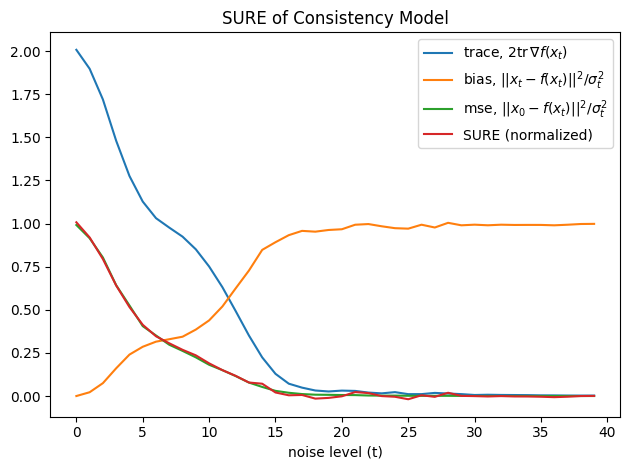

In [30]:
#traces = [_.clone().detach().cpu() for _ in TRACES_SAVE]

#traces_plot = [2 * sigma**2 * TRACES_SAVE[i].clone().detach().cpu() for i, sigma in enumerate(reversed(sigmas)[1:])]
traces_plot = [2 * TRACES_SAVE[i].clone().detach().cpu() / 12288  for i, sigma in enumerate(reversed(sigmas)[1:])]
bias_plot = [BIAS_SAVE[i].clone().detach().cpu() / sigma**2 / 12288 for i, sigma in enumerate(reversed(sigmas)[1:])]
mse_plot = [MSE_SAVE[i].clone().detach().cpu() / sigma**2 / 12288  for i, sigma in enumerate(reversed(sigmas)[1:])]

plt.plot(traces_plot, label="trace, $2 \\text{tr} \\, \\nabla f(x_t)$")
#plt.plot(traces, label="trace, $\\text{tr} \\, \\nabla f(x_t)$")
plt.plot(bias_plot, label="bias, $||x_t - f(x_t)||^2 / \\sigma_t^2$")
plt.plot(mse_plot, label="mse, $||x_0 - f(x_t)||^2 / \\sigma_t^2$")

SURE = [
    (TRACES_SAVE[i] * 2
    + BIAS_SAVE[i] / sigma**2
    - 12288) / 12288 
    for i, sigma in enumerate(reversed(sigmas)[1:]) 
]

plt.plot(SURE, label="SURE (normalized)")

#plt.ylim((-1e3, 0.5e6))
#plt.plot(SURE[::-1])

plt.xlabel("noise level (t)")
plt.title("SURE of Consistency Model")
plt.legend()

plt.tight_layout()

#plt.yscale("log")


plt.savefig("jul24/SURE.jpg", dpi=400)

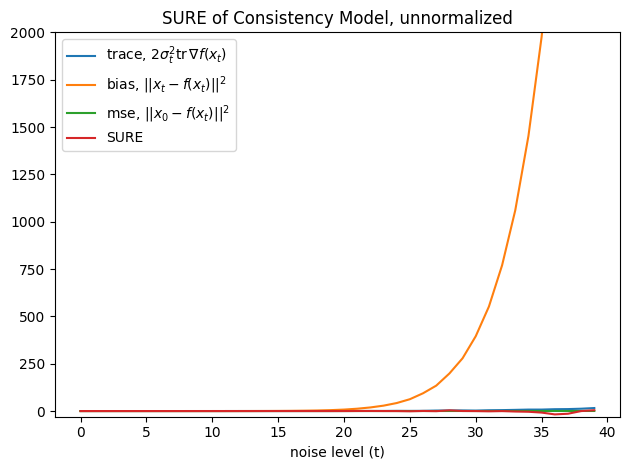

In [32]:
#traces = [_.clone().detach().cpu() for _ in TRACES_SAVE]

traces_plot = [2 * sigma**2 * TRACES_SAVE[i].clone().detach().cpu() / 12288 for i, sigma in enumerate(reversed(sigmas)[1:])]
#bias_plot = BIAS_SAVE
#mse_plot = MSE_SAVE
bias_plot = [BIAS_SAVE[i].clone().detach().cpu() / 12288 for i, sigma in enumerate(reversed(sigmas)[1:])]
mse_plot = [MSE_SAVE[i].clone().detach().cpu() / 12288  for i, sigma in enumerate(reversed(sigmas)[1:])]




plt.plot(traces_plot, label="trace, $2  \\sigma_t^2 \\text{tr} \\, \\nabla f(x_t)$")
#plt.plot(traces, label="trace, $\\text{tr} \\, \\nabla f(x_t)$")
plt.plot(bias_plot, label="bias, $||x_t - f(x_t)||^2 $")
plt.plot(mse_plot, label="mse, $||x_0 - f(x_t)||^2 $")

SURE = [
    (TRACES_SAVE[i] * 2 * sigma**2
    + BIAS_SAVE[i] 
    - 12288 * sigma**2) / 12288
    for i, sigma in enumerate(reversed(sigmas)[1:]) 
]

plt.plot(SURE, label="SURE")

#plt.plot(SURE[::-1])

plt.xlabel("noise level (t)")
plt.title("SURE of Consistency Model, unnormalized")
plt.legend()

plt.tight_layout()
#plt.yscale("log")
plt.ylim((-30, 2000))

plt.savefig("jul24/SURE_unnormalized.jpg", dpi=400)

- plot against sigma
- basis functions + noise

- has anyone considered taking a model that goes from a binary vector to an image
- different noise realizations give same image?
- check doni